This jupyter notebook includes some useful functions and visualization that inserted in the write-up.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split

In [2]:
# function for importing dataset
def import_data(filepath):
    folder_path = filepath
    training = []
    authors = []
    for filename in glob.glob(os.path.join(folder_path, "*/")):
        author = filename.split('/')[-2]
        for article in glob.glob(os.path.join(filename, '*.txt')):
            with open(article, 'r') as file:
                data = file.read()
                training.append(data)
                authors.append(author)

    return training, authors


# function for loading function words
def load_function_words(resource_path):
    """load a newline separated text file of function words.
    Return a list"""
    f_words = []
    with open(resource_path, 'r') as f:
        for line in f:
            if line.strip():
                f_words.append(line.lower().strip())
    return f_words


# function for shuffling
def shuffle(X, y):
    np.random.seed(521)
    new_order = np.random.permutation(len(X))

    X_shuffle = np.asarray(X)
    y_shuffle = np.asarray(y)
    return X_shuffle[new_order], y_shuffle[new_order]

In [3]:
# function for preprocessing text
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    text_lower = [t.lower() for t in text]
    text_tokens = [word_tokenize(t) for t in text_lower]
    text_tokens_stop = []

    for sent in tqdm(text_tokens):
        text_tokens_stop.append([ps.stem(w) for w in sent if w not in stop_words and w.isalpha()])

    return text_tokens_stop


# function for building a matrix of function words features
def function_words_features(tokens):
    function_words = load_function_words("ewl_function_words.txt")
    X = np.zeros(shape=(len(tokens), len(function_words)))
    for i, s in tqdm(enumerate(tokens)):
        for t in s:
            for j, fw in enumerate(function_words):
                if fw == t:
                    X[i][j] += 1
    return X


# function for building a matrix of structure features
def structure_features(tokens):
    tokens_len = []
    for row in tokens:
        tmp = []
        for token in row:
            tmp.append(len(token))
        tokens_len.append(tmp)

    X_structure = np.zeros(shape=(len(tokens), 7))
    for i in range(len(tokens_len)):
        row = tokens_len[i]
        tmp = np.asarray(row)
        X_structure[i][0] = np.mean(tmp)
        X_structure[i][1] = np.max(tmp)
        X_structure[i][2] = np.min(tmp)
        X_structure[i][3] = np.percentile(tmp, 10)
        X_structure[i][4] = np.percentile(tmp, 20)
        X_structure[i][5] = np.percentile(tmp, 80)
        X_structure[i][6] = np.percentile(tmp, 90)

    return X_structure


# function for 2-gram features
def ngram_features(train, test, n=2, features=500):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=features)
    train_corpus = [" ".join(token) for token in train]
    test_corpus = [" ".join(token) for token in test]
    vectorizer.fit(train_corpus + test_corpus)
    X_train = vectorizer.transform(train_corpus)
    X_test = vectorizer.transform(test_corpus)
    return X_train, X_test

## plot some histograms that help getting insights about structure features

In [4]:
import matplotlib.pyplot as plt

texts, authors = import_data('./C50/C50train')
test_texts, y_test = import_data('./C50/C50test')

In [5]:
all_texts = texts + test_texts

In [6]:
all_tokens = preprocess(all_texts)

100%|██████████| 5000/5000 [00:30<00:00, 165.45it/s]


In [7]:
para_len = np.asarray([len(tokens) for tokens in all_tokens])

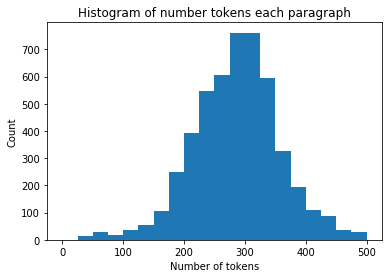

In [8]:
plt.hist(para_len, range=(0,500), bins=20)
plt.title("Histogram of number tokens each paragraph")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.show() 

In [9]:
structure_tokens = structure_features(all_tokens)

In [10]:
structure_tokens[0]

array([ 5.21411765, 12.        ,  1.        ,  3.        ,  4.        ,
        7.        ,  8.        ])

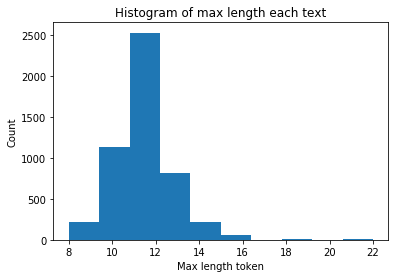

In [20]:
plt.hist(structure_tokens[:,1])
plt.title("Histogram of max length each text")
plt.xlabel("Max length token")
plt.ylabel("Count")
plt.show() 

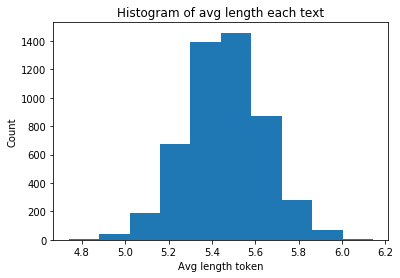

In [22]:
plt.hist(structure_tokens[:,0])
plt.title("Histogram of avg length each text")
plt.xlabel("Avg length token")
plt.ylabel("Count")
plt.show() 

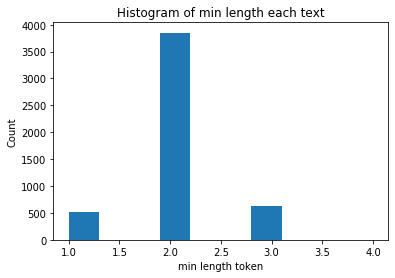

In [23]:
plt.hist(structure_tokens[:,2])
plt.title("Histogram of min length each text")
plt.xlabel("min length token")
plt.ylabel("Count")
plt.show() 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [15]:
all_labels = authors + y_test
le = preprocessing.LabelEncoder()
all_labels = le.fit_transform(all_labels)
print(len(all_tokens), len(all_labels))

5000 5000


In [16]:
all_tokens, labels = shuffle(all_tokens, all_labels)

X_train, X_test, y_train, y_test = train_test_split(all_tokens, labels, test_size=0.3)

In [18]:
print("Structure Features")
X_structure = structure_features(X_train)
X_structure_test = structure_features(X_test)
clf_svc = svm.SVC(decision_function_shape='ovo')
clf_svc.fit(X_structure, y_train)
print("Train:", clf_svc.score(X_structure, y_train))
print("Test:", clf_svc.score(X_structure_test, y_test))
clf_log = LogisticRegression(random_state=0).fit(X_structure, y_train)
print("log train:", accuracy_score(y_train, clf_log.predict(X_structure)))
print("log test:", accuracy_score(y_test, clf_log.predict(X_structure_test)))

Structure Features
Train: 0.08514285714285715
Test: 0.05266666666666667
log train: 0.09228571428571429
log test: 0.06933333333333333


/Users/xiyuchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## UMAP visualization

In [19]:
import umap
import umap.plot

/Users/xiyuchen/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


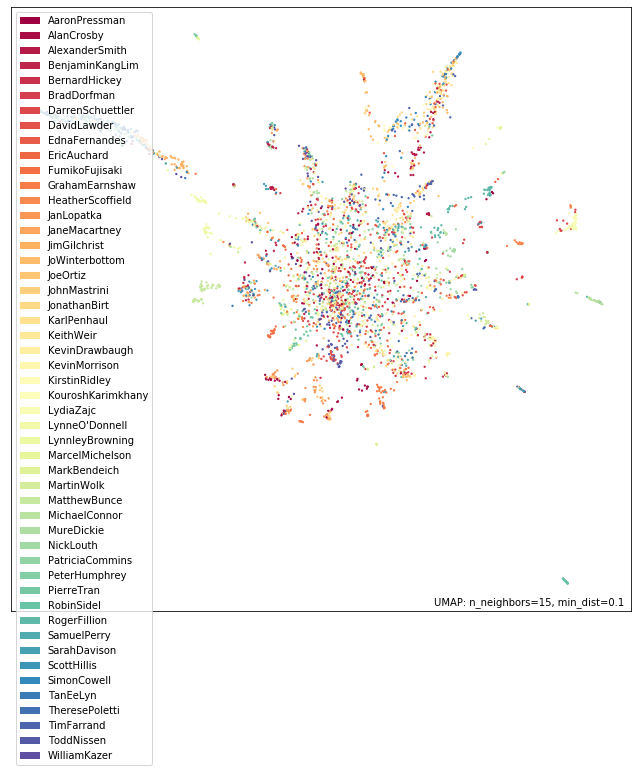

In [39]:
X_2gram, X_2gram_test = ngram_features(X_train, X_test)
mapper = umap.UMAP().fit(X_2gram)


/Users/xiyuchen/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


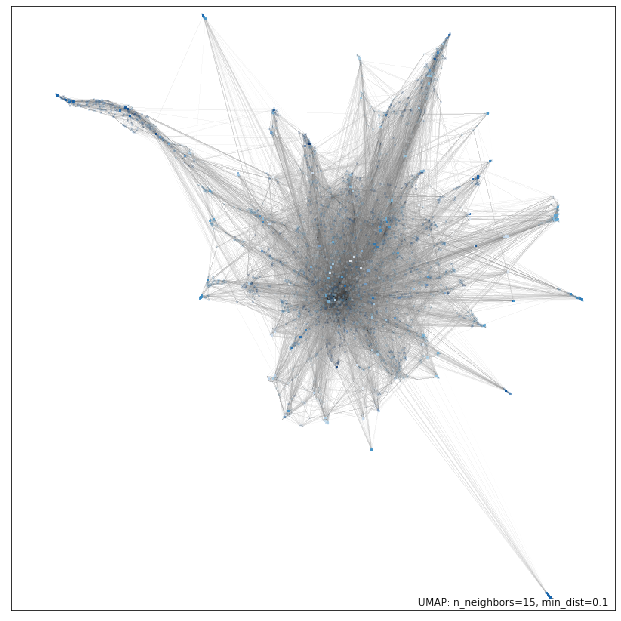

In [42]:
umap.plot.connectivity(mapper, values=y_train, show_points=True)


In [43]:
X_2gram, X_2gram_test = ngram_features(X_train, X_test, n=1)
mapper = umap.UMAP().fit(X_2gram)

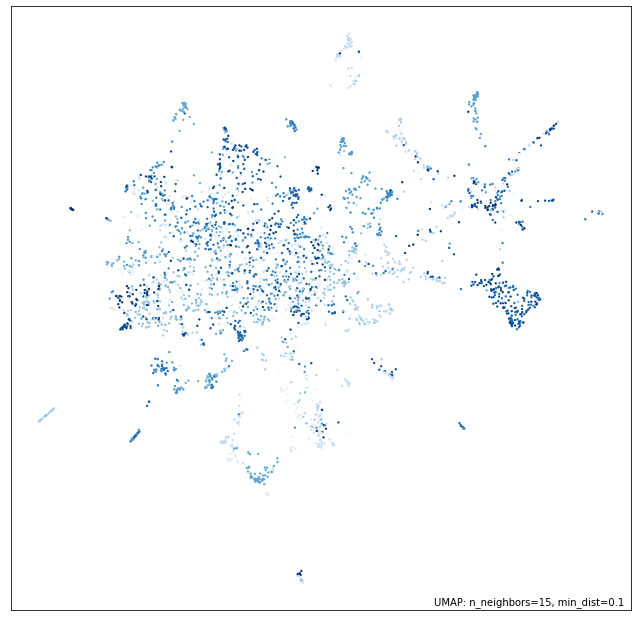

In [44]:
umap.plot.points(mapper, values=y_train)

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
X_freq, X_freq_test = ngram_features(X_train, X_test, n=1)
clf_svc_ngram = svm.SVC(decision_function_shape='ovo')
clf_svc_ngram.fit(X_freq, y_train)
print("Train:", clf_svc_ngram.score(X_freq, y_train))
print("Test:", clf_svc_ngram.score(X_freq_test, y_test))

Train: 0.9365714285714286
Test: 0.748


In [30]:
y_pred = le.inverse_transform(clf_svc_ngram.predict(X_freq_test))
y_true =  le.inverse_transform(y_test)
print(confusion_matrix(y_true, y_pred))

[[21  0  1 ...  0  0  0]
 [ 0 27  0 ...  0  0  0]
 [ 0  0 24 ...  0  0  0]
 ...
 [ 0  0  1 ... 22  0  0]
 [ 0  0  0 ...  0 21  0]
 [ 1  0  0 ...  0  0 16]]


In [31]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

                   precision    recall  f1-score   support

    AaronPressman      0.750     0.913     0.824        23
       AlanCrosby      0.900     0.844     0.871        32
   AlexanderSmith      0.857     0.727     0.787        33
  BenjaminKangLim      0.432     0.679     0.528        28
    BernardHickey      0.815     0.611     0.698        36
      BradDorfman      0.750     0.700     0.724        30
 DarrenSchuettler      0.909     0.800     0.851        25
      DavidLawder      0.774     0.750     0.762        32
    EdnaFernandes      0.686     0.800     0.738        30
      EricAuchard      0.720     0.581     0.643        31
   FumikoFujisaki      0.966     1.000     0.982        28
   GrahamEarnshaw      0.667     0.800     0.727        25
 HeatherScoffield      0.600     0.750     0.667        28
       JanLopatka      0.562     0.818     0.667        22
    JaneMacartney      0.552     0.516     0.533        31
     JimGilchrist      0.906     0.906     0.906       